# Project Goals

Things to investigate:

- Home vs Away: Is there a difference in results and style of play?
- Effect on play of conceding a goal : Are you most vulnerable to conceding straight after scoring?
- What is the most important factor to match result?
- Are there any conceivable differences between men and womens game?

Capturing style of play is essential. These can be ascertained via various stats. For example:

- Shot Stats: Shot rate and average distance from goal
- Pass/Possession Stats: Possession (in each part of pitch) and mean length and direction  

In [2]:
library(StatsBombR)
library(tidyverse)

competitions <- FreeCompetitions();


[1] "Whilst we are keen to share data and facilitate research, we also urge you to be responsible with the data. Please register your details on https://www.statsbomb.com/resource-centre and read our User Agreement carefully."


In [3]:
head(competitions)

competition_id,season_id,country_name,competition_name,competition_gender,season_name,match_updated,match_available
<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
37,42,England,FA Women's Super League,female,2019/2020,2019-12-03T03:42:59.581,2019-12-03T03:42:59.581
37,4,England,FA Women's Super League,female,2018/2019,2019-10-27T11:05:58.079,2019-10-27T11:05:58.079
43,3,International,FIFA World Cup,male,2018,2019-06-23T12:38:35.142,2019-06-23T12:38:35.142
11,27,Spain,La Liga,male,2015/2016,2019-11-20T10:20:40.270,2019-11-20T10:20:40.270
11,26,Spain,La Liga,male,2014/2015,2019-07-30T12:42:05.563,2019-07-30T12:42:05.563
11,25,Spain,La Liga,male,2013/2014,2019-07-24T19:44:48.866,2019-07-24T19:44:48.866


In [4]:
# Select competition
compID = 43
competition = filter(competitions,competition_id==compID)

# Extract all match info for competition
matches <- FreeMatches(competition)

[1] "Whilst we are keen to share data and facilitate research, we also urge you to be responsible with the data. Please register your details on https://www.statsbomb.com/resource-centre and read our User Agreement carefully."


In [5]:
# Download Event Data for selected matches
eventData <- StatsBombFreeEvents(MatchesDF = matches, Parallel = T)

[1] "Whilst we are keen to share data and facilitate research, we also urge you to be responsible with the data. Please register your details on https://www.statsbomb.com/resource-centre and read our User Agreement carefully."


Warning message in if (MatchesDF == "ALL") {:
“the condition has length > 1 and only the first element will be used”


In [6]:
# Append useful info to event dataframe
eventData <- allclean(eventData)

Joining, by = "id"
Joining, by = "id"
Joining, by = "id"
Joining, by = "id"
Joining, by = "id"
Joining, by = "id"
Joining, by = "id"
Joining, by = "id"
Joining, by = "id"
Joining, by = "id"
Joining, by = "id"
Joining, by = "id"
Joining, by = "id"
Joining, by = "id"
Joining, by = "id"
Joining, by = "id"
Joining, by = "id"
Joining, by = c("period", "match_id")


In [7]:
# For convenience we join the match info to events dataframe
eventData <- left_join(eventData, matches, by = "match_id")

## Match Events

World Cup 2018: We have 64 matches with an average of 3560 events recorded in a match 

In [8]:
matchIDs = eventData %>% select(match_id) %>% unique()
matchIDs = as.vector(matchIDs$match_id)

In [9]:
# Extract Stats for all matches 
rowCount = 0
for (matchID in matchIDs){
    
    matchEventData <- eventData %>% filter(match_id==matchID)
    
    rowCount = rowCount + nrow(matchEventData)
}

print( paste("Number of matches:",length(matchIDs)) )
print( paste("Average Number of Events per match in Competition:",rowCount/length(matchIDs)) )

[1] "Number of matches: 64"
[1] "Average Number of Events per match in Competition: 3560.46875"


In [10]:

get_home_away_column_names <- function(df){
    
    colNames = names(df)
    numCols = length(df)
    
    for (i in 1:numCols){
         if ( i<=(numCols/2) ){
             colNames[i] = paste('H_',colNames[i],sep="")
         }
        else{
        colNames[i] = paste('A_',colNames[i],sep="")
        }
    } 
    
    return(colNames)

} 


In [11]:
# Extract Stats for all matches 

df_match_stats = data.frame()

for (matchID in matchIDs){
    
    matchEventData <- eventData %>% filter(match_id==matchID)
    
    # Obtain match score
    team.name = c( unique(matchEventData$home_team.home_team_name), unique(matchEventData$away_team.away_team_name) )
    score = c( unique(matchEventData$home_score), unique(matchEventData$away_score) )
    df_Score = data.frame(team.name,score)
    df_Score$team.name <- as.character(df_Score$team.name)
    df_Score
    
    # Total number of shots taken by each team
    df_totalShots = matchEventData %>% group_by(team.name) %>% summarise( Shots = sum(type.name=="Shot") )
    
    # Total Number of shots on target by each team
    df_totalShotsOnTarget = matchEventData %>% group_by(team.name) %>% summarise( ShotsOnTarget = sum(type.name=="Shot" & shot.outcome.name %in% c('Goal','Post','Saved','Saved To Post') ) )
    
    # Mean Distance from goal from which shots were taken
    df_AvgShotDistance = matchEventData %>% filter(type.name=="Shot") %>% mutate(DistToGoal = sqrt((location.x - 120)^2 + (location.y - 40)^2)) %>% group_by(team.name) %>% summarise( AvgShotDistance = mean(DistToGoal,na.rm=T) ) 
    
    # Total expected goals of each team
    df_totalxG = matchEventData %>% group_by(team.name) %>% summarise( XG = sum(shot.statsbomb_xg,na.rm=T) )
    
    # Possession (Based on total number of passes)
    df_Possession = matchEventData %>% group_by(team.name) %>% summarise( Possession = sum(type.name=="Pass") )
    df_Possession$PctPossession = df_Possession$Possession/sum(df_Possession$Possession)
    
    # Possession stats in first, middle and third zones
    df_ZonePossession = matchEventData %>% filter(type.name=="Pass") %>% select( team.name, minute, location.x, location.y ) %>% mutate( firstThird=ifelse(location.x<40,1,0), middleThird=ifelse(location.x>=40 & location.x<=80,1,0), finalThird=ifelse(location.x>80,1,0) ) %>% group_by(team.name) %>% summarise( z1.passes = sum(firstThird), z2.passes = sum(middleThird), z3.passes = sum(finalThird) )
    df_ZonePossession$z1.pass.pct = df_ZonePossession$z1.passes/ df_Possession$Possession
    df_ZonePossession$z2.pass.pct = df_ZonePossession$z2.passes/ df_Possession$Possession
    df_ZonePossession$z3.pass.pct = df_ZonePossession$z3.passes/ df_Possession$Possession
    
    # Average Pass Length
    df_AvgPassLength = matchEventData %>% filter(type.name=="Pass") %>% group_by(team.name) %>% summarise( avg.pass.length = mean(pass.length,na.rm=T) )
    
    # Average Pass Length in first, middle and third zones
    df_AvgPassLengthZone1 = matchEventData %>% filter(type.name=="Pass" & location.x<40) %>% group_by(team.name) %>% summarise( avg.pass.length.z1 = mean(pass.length,na.rm=T) )
    df_AvgPassLengthZone2 = matchEventData %>% filter(type.name=="Pass" & (location.x>=40 & location.x<=80) ) %>% group_by(team.name) %>% summarise( avg.pass.length.z2 = mean(pass.length,na.rm=T) )
    df_AvgPassLengthZone3 = matchEventData %>% filter(type.name=="Pass" & location.x>80) %>% group_by(team.name) %>% summarise( avg.pass.length.z3 = mean(pass.length,na.rm=T) )
    
    # Average Resultant Pass Direction (and length)
    df_AvgPassDirn = matchEventData %>% filter(type.name=="Pass") %>% mutate( pass.vector = complex(real=pass.length*cos(pass.angle),imaginary=pass.length*sin(pass.angle)) ) %>% group_by(team.name) %>% summarise( length.of.resultant.pass = Mod(mean(pass.vector,na.rm=T)), dirn.of.resultant.pass = abs(Arg(mean(pass.vector,na.rm=T))*(180/pi)) )  
    
    # Average Pass Direction (and length) in each zone
    df_AvgPassDirnZone1 = matchEventData %>% filter(type.name=="Pass" & location.x<40) %>% mutate( pass.vector = complex(real=pass.length*cos(pass.angle),imaginary=pass.length*sin(pass.angle)) ) %>% group_by(team.name) %>% summarise( length.of.resultant.pass.z1 = Mod(mean(pass.vector,na.rm=T)), dirn.of.resultant.pass.z1 = abs(Arg(mean(pass.vector,na.rm=T))*(180/pi)) ) 
    df_AvgPassDirnZone2 = matchEventData %>% filter(type.name=="Pass" & (location.x>=40 & location.x<=80) ) %>% mutate( pass.vector = complex(real=pass.length*cos(pass.angle),imaginary=pass.length*sin(pass.angle)) ) %>% group_by(team.name) %>% summarise( length.of.resultant.pass.z2 = Mod(mean(pass.vector,na.rm=T)), dirn.of.resultant.pass.z2 = abs(Arg(mean(pass.vector,na.rm=T))*(180/pi)) )
    df_AvgPassDirnZone3 = matchEventData %>% filter(type.name=="Pass" & location.x>80) %>% mutate( pass.vector = complex(real=pass.length*cos(pass.angle),imaginary=pass.length*sin(pass.angle)) ) %>% group_by(team.name) %>% summarise( length.of.resultant.pass.z3 = Mod(mean(pass.vector,na.rm=T)), dirn.of.resultant.pass.z3 = abs(Arg(mean(pass.vector,na.rm=T))*(180/pi)) )
    
    # JOIN ALL above Stat dataframes into a single Stats dataframe
    df_MatchStats <- left_join(df_Score, df_totalShots, by = "team.name")
    df_MatchStats <- left_join(df_MatchStats, df_totalShotsOnTarget, by = "team.name")
    df_MatchStats <- left_join(df_MatchStats, df_AvgShotDistance, by = "team.name")
    df_MatchStats <- left_join(df_MatchStats, df_totalxG, by = "team.name")
    df_MatchStats <- left_join(df_MatchStats, df_Possession, by = "team.name")
    df_MatchStats <- left_join(df_MatchStats, df_AvgPassLength, by = "team.name")
    df_MatchStats <- left_join(df_MatchStats, df_AvgPassLengthZone1, by = "team.name")
    df_MatchStats <- left_join(df_MatchStats, df_AvgPassLengthZone2, by = "team.name")
    df_MatchStats <- left_join(df_MatchStats, df_AvgPassLengthZone3, by = "team.name")
    df_MatchStats <- left_join(df_MatchStats, df_AvgPassDirn, by = "team.name")
    df_MatchStats <- left_join(df_MatchStats, df_AvgPassDirnZone1, by = "team.name")
    df_MatchStats <- left_join(df_MatchStats, df_AvgPassDirnZone2, by = "team.name")
    df_MatchStats <- left_join(df_MatchStats, df_AvgPassDirnZone3, by = "team.name")
    df_MatchStats <- left_join(df_MatchStats, df_ZonePossession, by = "team.name")
    
    # Reformat data into single row
    matchStatsRow = cbind( df_MatchStats[1,] , df_MatchStats[2,] )

    # Rename column names so that home and away team stats are clearly labelled
    names(matchStatsRow) <- get_home_away_column_names(matchStatsRow)
    
    # Append season name, match id and match date
    matchDetails <- matchEventData %>% select( season.season_name, match_id, match_date ) %>% unique()
    names(matchDetails) = c('season_name', 'match_id', 'match_date')
    matchStatsRow = cbind(matchDetails,matchStatsRow)
    
    # Append row to master dataframe
    df_match_stats = rbind(df_match_stats,matchStatsRow)
}


In [12]:
head(df_match_stats)


season_name,match_id,match_date,H_team.name,H_score,H_Shots,H_ShotsOnTarget,H_AvgShotDistance,H_XG,H_Possession,⋯,A_length.of.resultant.pass.z2,A_dirn.of.resultant.pass.z2,A_length.of.resultant.pass.z3,A_dirn.of.resultant.pass.z3,A_z1.passes,A_z2.passes,A_z3.passes,A_z1.pass.pct,A_z2.pass.pct,A_z3.pass.pct
<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018,7525,2018-06-14,Russia,5,14,7,17.95756,1.159168,388,⋯,1.876147,16.8730148,1.263202,179.52255,174,303,95,0.3041958,0.5297203,0.1660839
2018,7529,2018-06-16,Croatia,2,11,2,18.85227,1.336756,503,⋯,5.690064,0.3517733,5.153295,58.30285,131,229,65,0.3082353,0.5388235,0.1529412
2018,7530,2018-06-16,France,2,12,4,21.70075,1.265828,549,⋯,4.847217,12.8627518,2.603630,18.66692,169,215,60,0.3806306,0.4842342,0.1351351
2018,7531,2018-06-16,Argentina,1,28,7,21.63288,1.772002,796,⋯,8.296556,10.9294874,6.035808,47.23801,84,89,51,0.3750000,0.3973214,0.2276786
2018,7532,2018-06-16,Peru,0,17,6,19.41227,1.969108,435,⋯,4.891277,2.9450968,3.265795,26.43318,92,191,119,0.2288557,0.4751244,0.2960199
2018,7533,2018-06-17,Brazil,1,21,4,18.11036,1.567336,555,⋯,5.306904,2.0766964,2.387515,11.83821,126,234,98,0.2751092,0.5109170,0.2139738


# Long Format

There is really no home/away distinction in the World Cup. So we will reformat, rename columns and add a results column


In [13]:
# Add Home and Away Result columns
df_world_cup = df_match_stats %>% mutate( H_Result = case_when( H_score > A_score ~ 'W', H_score == A_score ~ 'D', H_score < A_score ~ 'L') )
df_world_cup = df_world_cup %>% mutate( A_Result = case_when( H_score > A_score ~ 'L', H_score == A_score ~ 'D', H_score < A_score ~ 'W') )

# Now we find column names of all home team stats ... and away team stats
colNamesHome = names(df_world_cup) %>% str_subset(pattern = "^H_.*")
colNamesAway = names(df_world_cup) %>% str_subset(pattern = "^A_.*")

# We rejig dataframe and then construct new dataframe that is a mirror image 
df_world_cup_1 = df_world_cup[ c('match_id','match_date',colNamesHome,colNamesAway) ]
df_world_cup_2 = df_world_cup[ c('match_id','match_date',colNamesAway,colNamesHome) ]

# Rename columns
colNames = names(df_world_cup_1)
colNames = str_replace(colNames,'H_','')
colNames = str_replace(colNames,'A_','Opp_')
names(df_world_cup_1) = colNames
names(df_world_cup_2) = colNames

# Stack two dataframes on top of each other
df_world_cup = rbind(df_world_cup_1,df_world_cup_2)

# Clean up
rm(df_world_cup_1)
rm(df_world_cup_2)

In [ ]:
# Add Home and Away Result columns
#df_world_cup = df_match_stats %>% mutate( H_Result = case_when( H_score > A_score ~ 'W', H_score == A_score ~ 'D', H_score < A_score ~ 'L') )
#df_world_cup = df_world_cup %>% mutate( A_Result = case_when( H_score > A_score ~ 'L', H_score == A_score ~ 'D', H_score < A_score ~ 'W') )

# Now we split up the stats for both teams into separate dataframes 
#colNames = names(df_world_cup) %>% str_subset(pattern = "^H_.*")
#df_home_team = df_world_cup[ c('match_id','match_date',colNames) ]

#colNames = names(df_world_cup) %>% str_subset(pattern = "^A_.*")
#df_away_team = df_world_cup[ c('match_id','match_date',colNames) ]

# Rename columns in both dataframes 
#colNames = names(df_home_team)
#colNames = str_replace(colNames,'H_','')
#names(df_home_team) = colNames

#colNames = names(df_away_team)
#colNames = str_replace(colNames,'A_','')
#names(df_away_team) = colNames

# Stack them on top of each other
#df_world_cup = rbind(df_home_team,df_away_team)

In [14]:
write.csv(df_world_cup,"World_Cup_2018_Match_Stats.csv", row.names = FALSE)


# Data Exploration

In [16]:
library("PerformanceAnalytics")


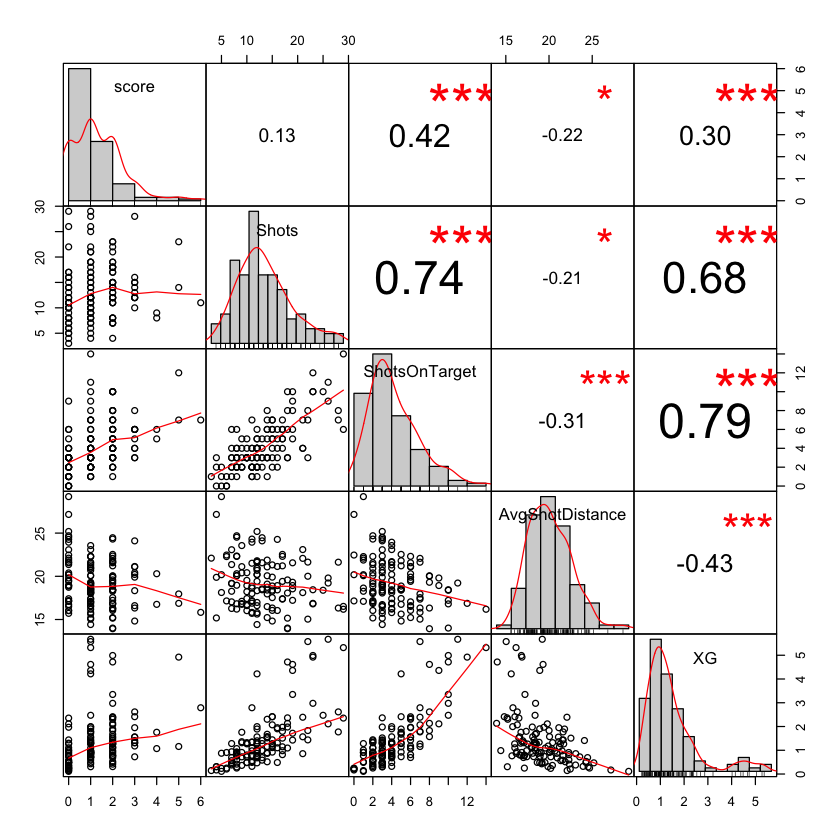

In [17]:
df = df_world_cup[c('score','Shots','ShotsOnTarget','AvgShotDistance','XG')]
chart.Correlation(df, histogram=TRUE, pch=19)


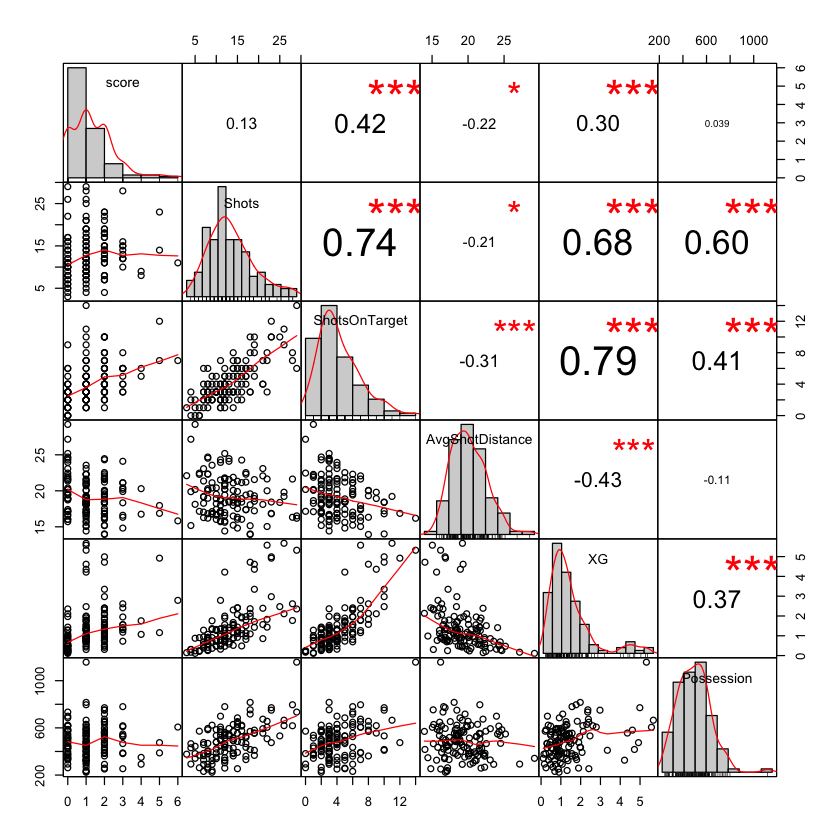

In [18]:
df = df_world_cup[c('score','Shots','ShotsOnTarget','AvgShotDistance','XG','Possession')]
chart.Correlation(df, histogram=TRUE, pch=19)


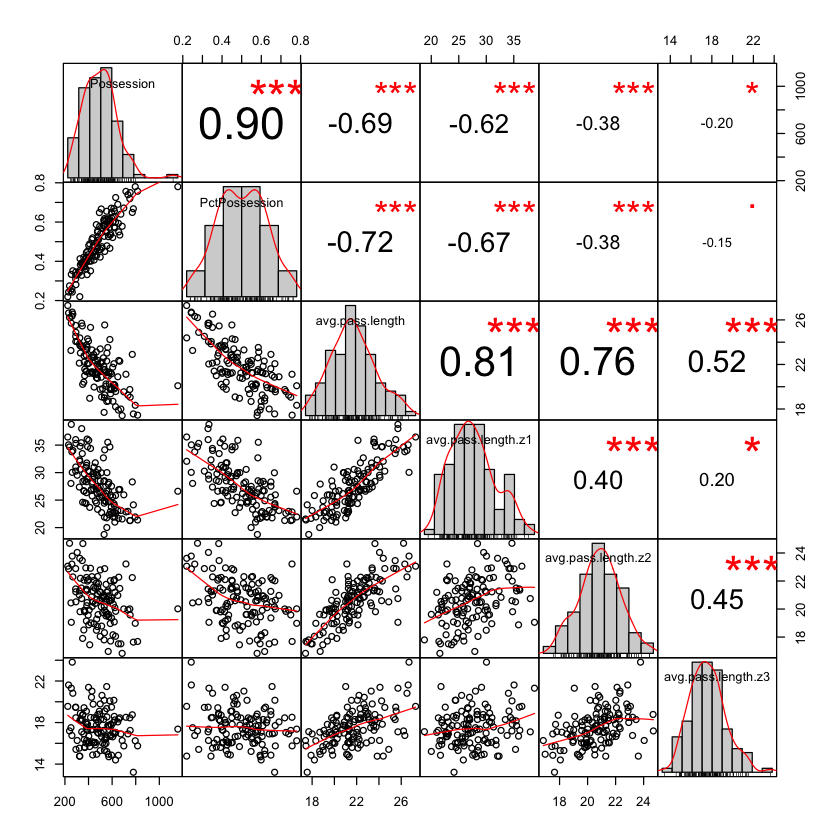

In [19]:
df = df_world_cup[c('Possession','PctPossession','avg.pass.length','avg.pass.length.z1','avg.pass.length.z2','avg.pass.length.z3')]
chart.Correlation(df, histogram=TRUE, pch=19)

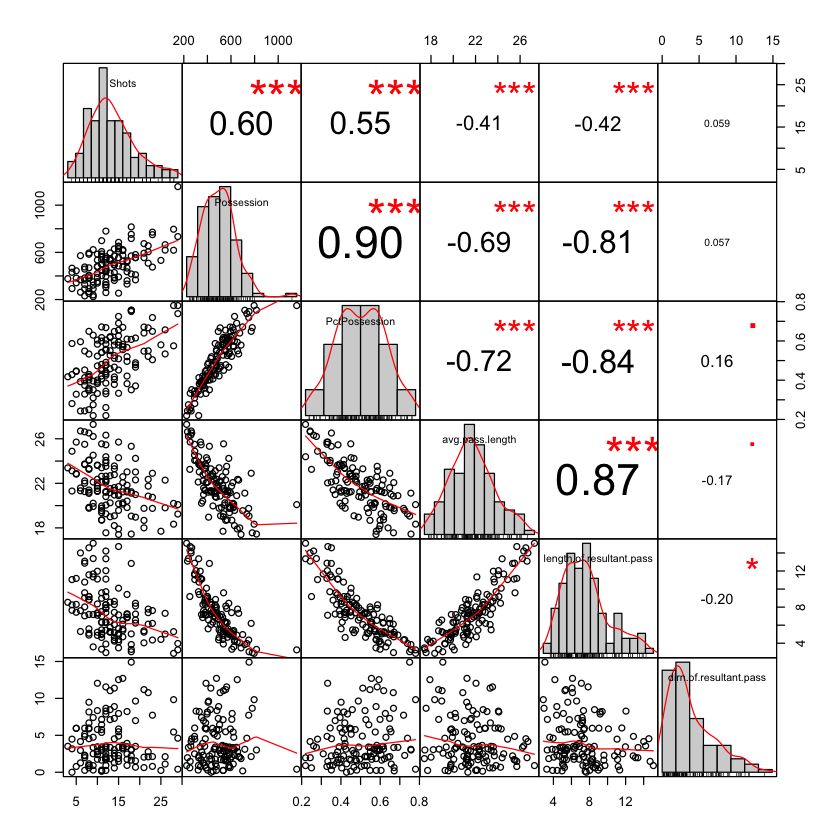

In [20]:
df = df_world_cup[c('Shots','Possession','PctPossession','avg.pass.length','length.of.resultant.pass','dirn.of.resultant.pass')]
chart.Correlation(df, histogram=TRUE, pch=19)

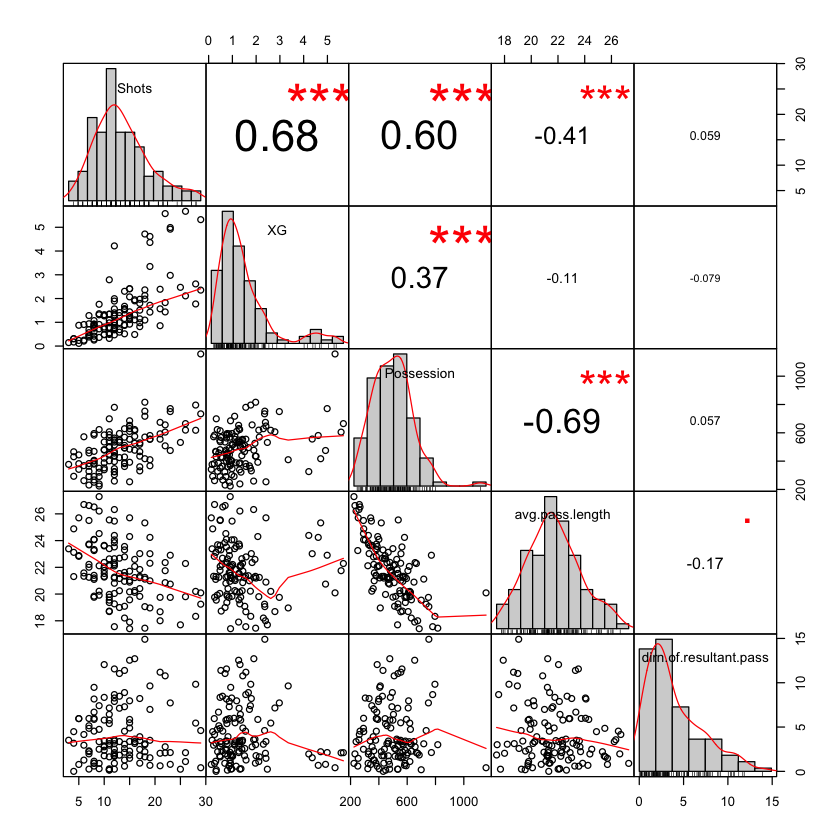

In [21]:
df = df_world_cup[c('Shots','XG','Possession','avg.pass.length','dirn.of.resultant.pass')]
chart.Correlation(df, histogram=TRUE, pch=19)

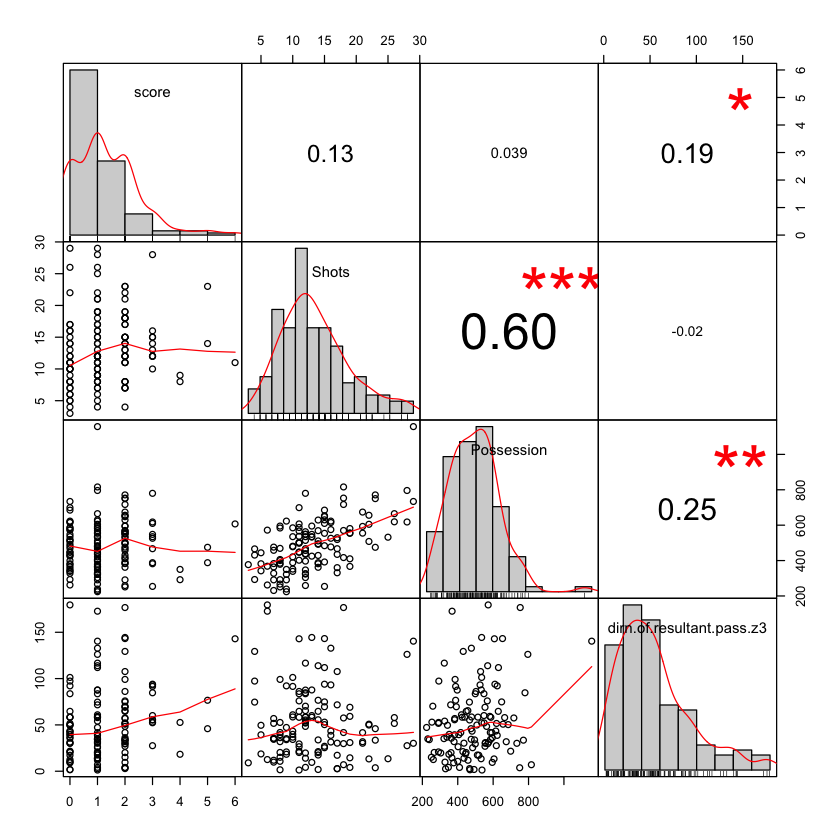

In [22]:
df = df_world_cup[c('score','Shots','Possession','dirn.of.resultant.pass.z3')]
chart.Correlation(df, histogram=TRUE, pch=19)

In [23]:
names(df_world_cup)



[1] "match_id"                        "match_date"                     
 [3] "team.name"                       "score"                          
 [5] "Shots"                           "ShotsOnTarget"                  
 [7] "AvgShotDistance"                 "XG"                             
 [9] "Possession"                      "PctPossession"                  
[11] "avg.pass.length"                 "avg.pass.length.z1"             
[13] "avg.pass.length.z2"              "avg.pass.length.z3"             
[15] "length.of.resultant.pass"        "dirn.of.resultant.pass"         
[17] "length.of.resultant.pass.z1"     "dirn.of.resultant.pass.z1"      
[19] "length.of.resultant.pass.z2"     "dirn.of.resultant.pass.z2"      
[21] "length.of.resultant.pass.z3"     "dirn.of.resultant.pass.z3"      
[23] "z1.passes"                       "z2.passes"                      
[25] "z3.passes"                       "z1.pass.pct"                    
[27] "z2.pass.pct"                     "z3.pass.pct"                    
[29] "Result"                          "Opp_team.name"                  
[31] "Opp_score"                       "Opp_Shots"                      
[33] "Opp_ShotsOnTarget"               "Opp_AvgShotDistance"            
[35] "Opp_XG"                          "Opp_Possession"                 
[37] "Opp_PctPossession"               "Opp_avg.pass.length"            
[39] "Opp_avg.pass.length.z1"          "Opp_avg.pass.length.z2"         
[41] "Opp_avg.pass.length.z3"          "Opp_length.of.resultant.pass"   
[43] "Opp_dirn.of.resultant.pass"      "Opp_length.of.resultant.pass.z1"
[45] "Opp_dirn.of.resultant.pass.z1"   "Opp_length.of.resultant.pass.z2"
[47] "Opp_dirn.of.resultant.pass.z2"   "Opp_length.of.resultant.pass.z3"
[49] "Opp_dirn.of.resultant.pass.z3"   "Opp_z1.passes"                  
[51] "Opp_z2.passes"                   "Opp_z3.passes"                  
[53] "Opp_z1.pass.pct"                 "Opp_z2.pass.pct"                
[55] "Opp_z3.pass.pct"                 "Opp_Result"

In [35]:
names(eventData)

[1] "id"                             "index"                         
  [3] "period"                         "timestamp"                     
  [5] "minute"                         "second"                        
  [7] "possession"                     "duration"                      
  [9] "related_events"                 "location"                      
 [11] "under_pressure"                 "counterpress"                  
 [13] "type.id"                        "type.name"                     
 [15] "possession_team.id"             "possession_team.name"          
 [17] "play_pattern.id"                "play_pattern.name"             
 [19] "team.id"                        "team.name"                     
 [21] "tactics.formation"              "tactics.lineup"                
 [23] "player.id"                      "player.name"                   
 [25] "position.id"                    "position.name"                 
 [27] "pass.length"                    "pass.angle"                    
 [29] "pass.end_location"              "pass.cross"                    
 [31] "pass.aerial_won"                "pass.switch"                   
 [33] "pass.backheel"                  "pass.assisted_shot_id"         
 [35] "pass.shot_assist"               "pass.goal_assist"              
 [37] "pass.recipient.id"              "pass.recipient.name"           
 [39] "pass.height.id"                 "pass.height.name"              
 [41] "pass.body_part.id"              "pass.body_part.name"           
 [43] "pass.type.id"                   "pass.type.name"                
 [45] "pass.outcome.id"                "pass.outcome.name"             
 [47] "carry.end_location"             "dribble.overrun"               
 [49] "dribble.nutmeg"                 "dribble.outcome.id"            
 [51] "dribble.outcome.name"           "duel.type.id"                  
 [53] "duel.type.name"                 "duel.outcome.id"               
 [55] "duel.outcome.name"              "ball_receipt.outcome.id"       
 [57] "ball_receipt.outcome.name"      "ball_recovery.recovery_failure"
 [59] "interception.outcome.id"        "interception.outcome.name"     
 [61] "block.offensive"                "shot.statsbomb_xg"             
 [63] "shot.end_location"              "shot.key_pass_id"              
 [65] "shot.freeze_frame"              "shot.first_time"               
 [67] "shot.aerial_won"                "shot.body_part.id"             
 [69] "shot.body_part.name"            "shot.technique.id"             
 [71] "shot.technique.name"            "shot.type.id"                  
 [73] "shot.type.name"                 "shot.outcome.id"               
 [75] "shot.outcome.name"              "goalkeeper.end_location"       
 [77] "goalkeeper.position.id"         "goalkeeper.position.name"      
 [79] "goalkeeper.type.id"             "goalkeeper.type.name"          
 [81] "goalkeeper.body_part.id"        "goalkeeper.body_part.name"     
 [83] "goalkeeper.technique.id"        "goalkeeper.technique.name"     
 [85] "goalkeeper.outcome.id"          "goalkeeper.outcome.name"       
 [87] "foul_won.defensive"             "foul_won.advantage"            
 [89] "foul_committed.advantage"       "foul_committed.offensive"      
 [91] "foul_committed.card.id"         "foul_committed.card.name"      
 [93] "substitution.outcome.id"        "substitution.outcome.name"     
 [95] "substitution.replacement.id"    "substitution.replacement.name" 
 [97] "50_50.outcome.id"               "50_50.outcome.name"            
 [99] "bad_behaviour.card.id"          "bad_behaviour.card.name"       
[101] "match_id"                       "competition_id"                
[103] "season_id"                      "pass.deflected"                
[105] "pass.cut_back"                  "shot.deflected"                
[107] "shot.redirect"                  "shot.one_on_one"               
[109] "ball_recovery.offensive"        "foul_committed.type.id"        
[111] "foul_committed.type.name"       "bl